In [47]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import os 
import sys
import seaborn as sns
import random

random.seed(20)

import time 
import datetime 


print(sys.version_info)

for module in mpl, np, pd, sklearn:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.18.1
pandas 0.24.2
sklearn 0.21.3


C:\Users\jinren\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:379: RuntimeWarning: Mean of empty slice.
C:\Users\jinren\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


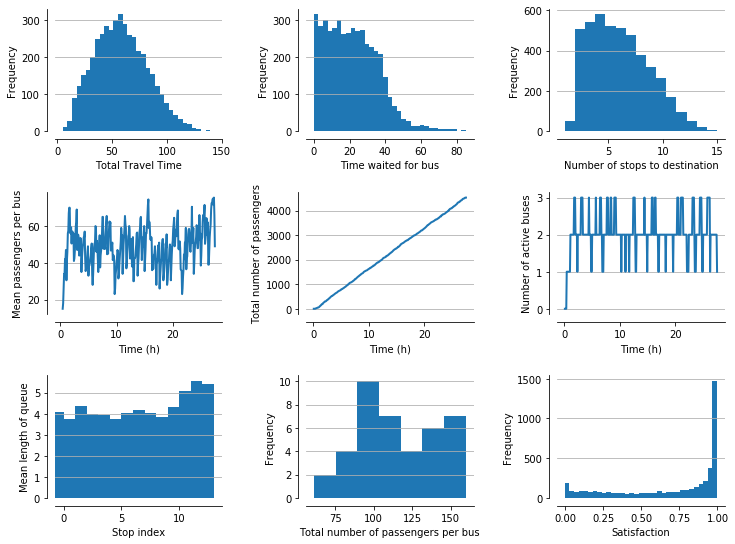

Mean satisfaction: 0.702
Mean number of passengers per bus: 113.17


In [1]:
# -*- coding: utf-8 -*-

"""
buslinesim
==========
Simulate a public transport circuit.  This simulation is not restricted, as its
name might imply, to bus circuits: it can also simulate train, metro, tramways
and other kinds of public transports.
The user specifies a number of parameters (number of stops, distance between
stops, probability distribution for passenger arrival, etc.) and then runs the
simulation.  At the end, various statistics can be accessed and analyzed
further using other tools.
"""

import heapq
import matplotlib

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm


class PrettyFig(matplotlib.figure.Figure):
    """Produce subplots similar to R's default plots.  This class only
    redefines ``matplotlib.figure.Figure``'s ``add_subplot`` method.  Only the
    left and bottom spines are shown, and they are positioned 8 pixels away
    from the plot region.  Moreover, the y-grid is turned on.
    Example
    -------
    To use this custom class, just pass the ``FigureClass`` argument to the
    ``plt.figure`` command.
        >>> x = np.linspace(0, 60, 500)
        >>> y = 0.5 * (1 - np.tanh(0.1*(x - 30)))
        >>> fig = plt.figure(FigureClass=PrettyFig)
        >>> plt.plot(x, y, linewidth=2)
        >>> plt.xlabel("Temps d'attente (min)")
        >>> plt.ylabel("Satisfaction")
    """
    def add_subplot(self, *args, **kwargs):
        ax = super(PrettyFig, self).add_subplot(*args, **kwargs)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.grid(axis='y')
        for loc, spine in ax.spines.items():
            if loc in ['left', 'bottom']:
                spine.set_position(('outward', 8))  # outward by 10 points
            elif loc in ['right', 'top']:
                spine.set_color('none')  # don't draw spine
            else:
                raise ValueError('unknown spine location: {}'.format(loc))
        return ax


class Passenger:
    """The ``Passenger`` class mostly serves as a structure for storing basic
    information about the time the passenger entered the system, the time she
    waited for the bus, the time she left the system, and her source and
    destination.  The sole method is to compute her satisfaction with the
    service.
    Properties
    ----------
    source: int
        Index of the bus stop at which the passenger enters the system.
    dest: int
        Index of the bus stop at which the passenger leaves the system.
    time_waited_for_bus: float
        Time between the moment the passenger enters the system and the moment
        a bus with places left arrives at the stop.
    satisfaction: float
        The satisfaction of the passenger with the service.  This should be a
        float between 0 and 1, 0 being absolutely dissatisfied and 1 being
        perfectly satisfied.
    start_time: float
        Time at which the passenger arrives at her source bus stop.
    end_time: float
        Time at which the passenger hops out of the bus.
    """
    def __init__(self, source=None, dest=None, start_time=0):
        self.source = source
        self.dest = dest
        self.time_waited_for_bus = None
        self.satisfaction = 1.0
        self.start_time = start_time
        self.end_time = None

    def satisfy(self):
        """Sigmoid satisfaction function."""
        self.satisfaction = (
            0.5 * (1 - np.tanh(0.1*(self.time_waited_for_bus - 30))))


class Bus:
    """The bus class holds some information about the position and the number
    of passengers.  It is responsible for letting passengers in and out of the
    bus.
    Properties
    ----------
    active: boolean
        If the bus is in circulation between the two terminals it is active.
        If the bus did not start its run or reached the last terminal and
        emptied all its passengers, it is inactive.
    position: float
        Position of the bus along the line.
    next_stop: int
        Index of the next stop on the bus's run.
    passengers: list of ``Passengers``
    size: int
        Maximum number of passengers that can fit in the bus, i.e., maximum
        length of the ``passengers`` list.
    last: boolean
        Indicates whether this bus is the last one in the simulation.  This is
        used to indicate the end of the simulation.  All buses but the last one
        should have this property set to False.
    total_passengers: int
        Total number of passengers the bus carried during its run so far.  This
        number includes not only the passengers currently in the bus, but also
        all passengers that already hoped out of the bus.
    """

    def __init__(self):
        self.active = False
        self.position = 0.0
        self.next_stop = 0
        self.passengers = []
        self.size = 100
        self.last = False
        self.total_passengers = 0

    @property
    def nb_free_places(self):
        """Return the number of places remaining in the bus."""
        return self.size - len(self.passengers)

    def hop_in(self, passengers):
        """Move ``passengers`` inside the bus.  ``passengers`` can be a single
        passenger or a list of passengers."""
        if np.iterable(passengers):
            self.passengers.extend(passengers)
            self.total_passengers += len(passengers)
        else:
            self.passengers.append(passengers)
            self.total_passengers += 1

    def hop_out(self, stop_index, cur_time, hop_out_time):
        """Passengers that reached their destination leave the bus.
        Arguments
        ---------
        stop_index: int
            Index of the stop at which the bus currently is.
        cur_time: float
            Current time in the simulation.
        hop_out_time: function
            Time it takes for a single passenger to leave the bus.  This
            function takes no argument.
        Returns
        -------
        t: float
            Time for passengers to leave the bus.
        out_passengers: list of ``Passengers``
            Passengers that left the bus.
        """
        out_passengers = [passenger for passenger in self.passengers
                          if passenger.dest == stop_index]
        t = 0.0
        for passenger in out_passengers:
            passenger.end_time = cur_time
            self.passengers.remove(passenger)
            t += hop_out_time()
        return t, out_passengers

    def empty(self, cur_time):
        """This function is called when the bus reaches the last stop.  All the
        passengers hop out of the bus.
        Returns
        -------
        out_passengers: list of ``Passengers``
            Passengers that left the bus.
        """
        for passenger in self.passengers:
            passenger.end_time = cur_time
            passenger.dest = self.next_stop
        out_passengers = self.passengers
        self.passengers = []
        self.active = False
        return out_passengers


class BusStop:
    """A bus stop is located somewhere along the circuit.  New passengers
    arrive at the stop according to some specified distribution.  When a bus
    arrives at the stop, passengers hop into the bus on a 'first come, first
    served' policy, i.e., passengers are in a FIFO queue.
    Properties
    ----------
    passengers: list of ``Passengers``
        Passengers that are currently waiting at the bus stop.  This list
        represents the queue.
    position: float
        Position of the stop along the circuit.
    next_arrival_time: function
        Amount of time before the next passenger arrives at the stop.  This
        is a function that takes no argument.  For instance, if passengers
        arrive according to a Poisson process, the interarrival time is
        exponentially distributed.
    index: int
        Index of the bus stop along the circuit.
    """
    def __init__(self, position=0, arrival_func=lambda: 10.0, index=0):
        self.passengers = []
        self.position = position
        self.next_arrival_time = arrival_func  # time between arrivals
        self.index = index

    def passenger_arrival(self, cur_time, dest):
        """Add a new passenger to the queue.
        Arguments
        ---------
        cur_time: float
            Current time in the simulation.
        dest: int
            Index of the bus stop where the passenger wants to go.
        """
        passenger = Passenger(source=self.index,
                              dest=dest,
                              start_time=cur_time)
        self.passengers.append(passenger)

    def hop_in_bus(self, cur_time, hop_in_time, bus):
        """A bus arrives, all passengers that fit into the bus hop in, others
        stay at the bus stop.
        Arguments
        ---------
        cur_time: float
            Current time in the simulation.
        hop_in_time: function
            Time for one passenger to hop into the bus.  This function takes no
            argument.
        bus: ``Bus``
            Bus that arrives at the stop and into which passengers hop.
        Returns
        -------
        t: float
            Time it takes for passengers to hop into the bus.
        """
        nb_to_bus = min(bus.nb_free_places, len(self.passengers))
        t = 0.0
        for i in range(nb_to_bus):
            passenger = self.passengers.pop(0)
            passenger.time_waited_for_bus = cur_time - passenger.start_time
            passenger.satisfy()
            bus.hop_in(passenger)
            t += hop_in_time()
        return t


class Stats:
    """This object collects various statistics about the current simulation.
    It has a method to produce a nice figure showing this collected data.
    Properties
    ----------
    t: list of floats
        Times at which the measurements were taken.
    nb_active_buses: list of ints
        Number of active buses at each time.  This list has the same length as
        ``t``.
    nb_passengers_in_active_buses: list of integer arrays
        At each time, a sublist whose length is given in ``nb_active_buses``
        contains the number of passengers in each active bus.  This list has
        the same length as ``t``.
    len_queues_at_stop: list of integer arrays
        At each time, the sublist contains the number of passengers waiting at
        each stop in the circuit.  The length of each sublist is the number of
        stops in the circuit.  This list has the same length as ``t``.
    travel_times: array of floats
        List of the time each passenger was in the system, i.e., from the time
        the passenger arrived at a bus stop to the time she hoped out of the
        bus at her destination.  Only passengers for which the total travel
        time is known are taken into account.  The length of this list is the
        total number of passengers that reached their destination.
    waited_times: array of floats
        List of the time each passenger waited for a bus.  Only passengers for
        which the waited time is set, i.e., passengers that hoped into a bus,
        are taken into account.  The length of this list is the total number of
        passengers that hoped into a bus.
    nb_stops_traveled: array of ints
        Number of stops between the origin and the destination for each
        passenger.  The length of this list is the total number of passengers
        that entered the system.
    satisfaction: array of floats
        Satisfaction of each passenger.  The length of this list is the total
        number of passengers that entered the system.
    total_passengers: list of arrays of ints
        Total number of passengers served at each time.  This list has the same
        length as ``t``.
    distance_between_successive_buses: list of arrays of floats
        At each time, distance between successive active buses.  This list has
        the same length as ``t``.  The length of each array is one less than
        the number of active buses at that time.
    """
    def __init__(self):
        self.t = []
        self.nb_active_buses = []
        self.nb_passengers_in_active_buses = []
        self.len_queues_at_stops = []
        self.travel_times = []
        self.waited_times = []
        self.nb_stops_traveled = []
        self.satisfaction = []
        self.total_passengers = []
        self.distance_between_successive_buses = []

    def measure(self, cur_time, buses, stops, passengers):
        """Measure all quantities.  Quantities that depend on time are appended
        to the appropriate list.  Quantities that do not depend on time are
        recalculated.
        """
        self.t.append(cur_time)
        active_buses = [bus for bus in buses if bus.active]
        self.nb_active_buses.append(len(active_buses))
        self.nb_passengers_in_active_buses.append(
            np.array([len(bus.passengers) for bus in active_buses]))
        self.len_queues_at_stops.append(
            np.array([len(stop.passengers) for stop in stops]))
        self.total_passengers.append(
            np.array([bus.total_passengers for bus in buses]))
        self.travel_times = np.array([passenger.end_time - passenger.start_time
                                      for passenger in passengers
                                      if passenger.end_time is not None])
        self.waited_times = np.array([passenger.time_waited_for_bus
                                      for passenger in passengers
                                      if passenger.time_waited_for_bus
                                      is not None])
        self.nb_stops_traveled = np.array([passenger.dest - passenger.source
                                           for passenger in passengers])
        self.satisfaction = np.array([passenger.satisfaction
                                      for passenger in passengers])
        positions = sorted([bus.position for bus in active_buses])
        self.distance_between_successive_buses.append(np.diff(positions))

    def _nb_bins(self, x):
        """Use Rice rule for number of bins in histograms."""
        x = np.array(x)
        return int(np.ceil(2 * x ** (1.0/3.0)))

    def plot_travel_times(self, **kwargs):
        """Plot a histogram of travel times."""
        plt.hist(self.travel_times,
                 bins=self._nb_bins(len(self.travel_times)),
                 **kwargs)
        plt.xlabel('Total Travel Time')
        plt.ylabel('Frequency')

    def plot_waited_times(self, **kwargs):
        """Plot a histogram of waited times."""
        plt.hist(self.waited_times,
                 bins=self._nb_bins(len(self.waited_times)),
                 **kwargs)
        plt.xlabel('Time waited for bus')
        plt.ylabel('Frequency')

    def plot_stops_traveled(self, **kwargs):
        """Plot a histogram of the number of stops between origin and
        destination.
        """
        plt.hist(self.nb_stops_traveled,
                 bins=len(np.unique(self.nb_stops_traveled)),
                 **kwargs)
        plt.xlabel('Number of stops to destination')
        plt.ylabel('Frequency')

    def plot_mean_nb_passengers(self, **kwargs):
        """Plot the mean number of passengers in active buses as a function of
        time.
        """
        avg_nb_passengers = [nb_passengers.mean()
                             for nb_passengers
                             in self.nb_passengers_in_active_buses]
        plt.plot(self.t / 60.0, avg_nb_passengers, linewidth=2, **kwargs)
        plt.xlabel('Time (h)')
        plt.ylabel('Mean passengers per bus')

    def plot_total_passengers(self, **kwargs):
        """Plot the total number of passengers as a function of time."""
        plt.plot(self.t / 60.0, np.sum(self.total_passengers, axis=1),
                 linewidth=2, **kwargs)
        plt.xlabel('Time (h)')
        plt.ylabel('Total number of passengers')

    def plot_nb_active_buses(self, **kwargs):
        """Plot the number of active buses as a function of time."""
        plt.plot(self.t / 60.0, self.nb_active_buses, linewidth=2, **kwargs)
        plt.xlabel('Time (h)')
        plt.ylabel('Number of active buses')

    def plot_length_queues(self, **kwargs):
        """Plot a bar chart of the mean length of queue at each stop."""
        queues = np.array(self.len_queues_at_stops)
        nb_stops = np.size(queues, 1)
        plt.bar(np.arange(nb_stops) - 0.5, np.mean(queues, axis=0),
                width=1.0, **kwargs)
        plt.xlim(-0.75, nb_stops - 1.25)
        plt.xlabel('Stop index')
        plt.ylabel('Mean length of queue')

    def plot_total_passengers_per_bus(self, **kwargs):
        """Plot a histogram of the total number of passengers per bus."""
        plt.hist(self.total_passengers[-1],
                 bins=self._nb_bins(len(self.total_passengers[-1])),
                 **kwargs)
        plt.xlabel('Total number of passengers per bus')
        plt.ylabel('Frequency')

    def plot_satisfaction(self, **kwargs):
        """Plot a histogram of passenger satisfaction."""
        plt.hist(self.satisfaction,
                 bins=self._nb_bins(len(self.satisfaction)),
                 **kwargs)
        plt.xlabel('Satisfaction')
        plt.ylabel('Frequency')

    def plot(self, **kwargs):
        """Plot everything in a single figure."""
        self.t = np.array(self.t)
        fig = plt.figure(figsize=(12, 9), FigureClass=PrettyFig)
        fig.add_subplot(3, 3, 1)
        self.plot_travel_times(**kwargs)
        fig.add_subplot(3, 3, 2)
        self.plot_waited_times(**kwargs)
        fig.add_subplot(3, 3, 3)
        self.plot_stops_traveled(**kwargs)
        fig.add_subplot(3, 3, 4)
        self.plot_mean_nb_passengers(**kwargs)
        fig.add_subplot(3, 3, 5)
        self.plot_total_passengers(**kwargs)
        fig.add_subplot(3, 3, 6)
        self.plot_nb_active_buses(**kwargs)
        fig.add_subplot(3, 3, 7)
        self.plot_length_queues(**kwargs)
        fig.add_subplot(3, 3, 8)
        self.plot_total_passengers_per_bus(**kwargs)
        fig.add_subplot(3, 3, 9)
        self.plot_satisfaction(**kwargs)
        fig.subplots_adjust(wspace=0.5, hspace=0.5)


class Event:
    """The simulation works by processing events.  An event occurs at a
    specific time ``e_time`` and involves a specific object ``e_obj``.
    Comparing two events amounts to figuring out which event occurs first.
    """
    def __init__(self, e_time, e_obj):
        self.e_time = e_time
        self.e_obj = e_obj

    def __lt__(self, other):
        return self.e_time < other.e_time


class Simulation:
    """A simulation takes care of creating the buses, bus stops and passengers.
    It then execute a sequence of events until the last bus reaches the last
    stop at which point the simulation ends.
    Initialization
    --------------
    A simulation can be initialized with
    >>> sim = Simulation()
    The default values for the simulation are defined to give something
    reasonable, but they should be tuned based on available data.  By default,
    a simulation assumes time is measured in minutes, distance in kilometers
    and speed in kilometers per minute.  The full list of initialization
    options follows.
    bus_stop_positions: list or array
        Position of all bus stops in the simulation.  The number of bus stops
        is set equal to the length of this list.
        Default: ``np.arange(0, 30, 3)``
    passenger_arrival_times: function
        Time between two successive arrivals of passengers at a bus stop.  This
        function takes no arguments.
        Default: ``lambda: np.random.exponential(10.0)``
    hop_in_time: function
        Time for a passenger to hop into a bus.  This function takes no
        arguments.
        Default: ``lambda: truncnorm.rvs(-1, 8, loc=0.3, scale=0.2)``
    hop_out_time: function
        Time for a passenger to hop out of a bus.  This function takes no
        arguments.
        Default: ``lambda: truncnorm.rvs(-1, 8, loc=0.3, scale=0.2)``
    nb_stops_to_dest: function
        Number of stops between origin and destination for a passenger.  This
        function takes no arguments.
        Default: ``lambda: np.round(truncnorm.rvs(-1, 4, loc=4, scale=3))``
    bus_speed: function
        Bus speed between two successive stops.  This function takes no
        argument.
        Default: ``lambda: truncnorm.rvs(-2, 2, loc=0.83, scale=0.1)``
    nb_buses: int
        Number of buses in the simulation.
    time_between_buses: function
        Time between the arrival of two successive buses at the first bus stop.
        This function takes no argument.
        Default: ``lambda: 25``
    stats_time: float
        Time between measurement of statistics.
        Default: 5.0
    Statistics
    ----------
    Once the simulation has finished running, the statistics are available in
    the ``Stats`` object ``sim.stats``.
    Example
    -------
    >>> stop_pos = np.arange(0, 30, 2)
    >>> nb_stops = len(stop_pos)
    >>> mean_stops = nb_stops / 2.0
    >>> std_stops = nb_stops / 4.0
    >>> a = (1 - mean_stops) / std_stops
    >>> b = (nb_stops - mean_stops) / std_stops
    >>> stops_to_dest = lambda: np.round(truncnorm.rvs(a, b, loc=mean_stops,
    ...                                                scale=std_stops))
    >>> sim = Simulation(bus_stop_positions=stop_pos,
    ...          time_between_buses=lambda: 40,
    ...          nb_stops_to_dest=stops_to_dest,
    ...          passenger_arrival_times=lambda: np.random.exponential(5.0),
    ...          nb_buses=40)
    >>> sim.run()
    >>> sim.stats.plot()
    >>> print('Mean satisfaction: '
    ...       '{:.3f}'.format(np.mean(sim.stats.satisfaction)))
    >>> print('Mean number of passengers per bus: '
    ...       '{:.2f}'.format(np.mean(sim.stats.total_passengers[-1])))
    """

    def __init__(
            self,
            bus_stop_positions=np.arange(0, 30, 3),
            passenger_arrival_times=lambda: np.random.exponential(10.0),
            hop_in_time=lambda: truncnorm.rvs(-1, 8, loc=0.3, scale=0.2),
            hop_out_time=lambda: truncnorm.rvs(-1, 8, loc=0.3, scale=0.2),
            nb_stops_to_dest=lambda: np.round(truncnorm.rvs(-1, 4, loc=4,
                                                            scale=3)),
            bus_speed=lambda: truncnorm.rvs(-2, 2, loc=0.83, scale=0.1),
            nb_buses=50,
            time_between_buses=lambda: 25,
            stats_time=5.0):
        # Define stops
        self.bus_stop_positions = bus_stop_positions
        self.stops = [BusStop(position=pos, index=i,
                              arrival_func=passenger_arrival_times)
                      for i, pos in enumerate(self.bus_stop_positions)]
        # last stop, no one hops in
        self.stops[-1].next_arrival_time = lambda: np.Inf

        self.hop_in_time = hop_in_time
        self.hop_out_time = hop_out_time
        self.nb_stops_to_dest = nb_stops_to_dest
        self.bus_speed = bus_speed
        self.nb_buses = nb_buses
        self.time_between_buses = time_between_buses
        self.stats = None
        self.stats_time = stats_time

    def run(self):
        """Run the simulation.  The simulation works by maintaining a heap
        queue of events.  The events are processed until the last bus reaches
        the last stop.
        """
        moved_passengers = []
        events = []

        # Initialize events queue.
        for stop in self.stops:
            heapq.heappush(events, Event(stop.next_arrival_time(), stop))

        buses = []
        # first bus starts early to avoid over accumulation of passengers at
        # bus stops.
        t = 0.5 * self.time_between_buses()
        for i in range(self.nb_buses):
            bus = Bus()
            buses.append(bus)
            heapq.heappush(events, Event(t, bus))
            t += self.time_between_buses()
        buses[-1].last = True

        # Initialize statistics collection.
        self.stats = Stats()
        heapq.heappush(events, Event(self.stats_time, self.stats))

        while events:
            event = heapq.heappop(events)
            t, obj = event.e_time, event.e_obj
            if isinstance(obj, BusStop):
                # New arrival at a bus stop.
                dest = obj.index + self.nb_stops_to_dest()
                obj.passenger_arrival(t, dest=dest)
                heapq.heappush(events, Event(t + obj.next_arrival_time(), obj))
            elif isinstance(obj, Bus):
                if not obj.active:
                    obj.active = True
                if obj.next_stop >= len(self.stops):
                    # Bus reached terminal: it empties and becomes inactive.
                    moved_passengers.extend(obj.empty(t))
                    if obj.last:
                        break
                elif self.stops[obj.next_stop].position == obj.position:
                    # Bus reached a bus stop.
                    bus_stop = self.stops[obj.next_stop]
                    # Passengers hop out.
                    wait_out, passengers = obj.hop_out(
                        stop_index=bus_stop.index,
                        cur_time=t,
                        hop_out_time=self.hop_out_time)
                    moved_passengers.extend(passengers)
                    # Passengers hop in.
                    wait_in = bus_stop.hop_in_bus(t, self.hop_in_time, obj)
                    obj.next_stop += 1
                    heapq.heappush(events, Event(t + wait_out + wait_in, obj))
                else:
                    # Bus finished loading passengers, move to next stop.
                    dist = self.stops[obj.next_stop].position - obj.position
                    heapq.heappush(events,
                                   Event(t + self.bus_speed() * dist, obj))
                    obj.position += dist
            elif isinstance(obj, Stats):
                obj.measure(t, buses, self.stops, moved_passengers)
                heapq.heappush(events, Event(t + self.stats_time, obj))


if __name__ == '__main__':
    stop_pos = np.arange(0, 30, 2)
    nb_stops = len(stop_pos)
    mean_stops = nb_stops / 2.0
    std_stops = nb_stops / 4.0
    a, b = (1 - mean_stops) / std_stops, (nb_stops - mean_stops) / std_stops
    stops_to_dest = lambda: np.round(truncnorm.rvs(a, b, loc=mean_stops,
                                                   scale=std_stops))
    sim = Simulation(bus_stop_positions=stop_pos,
                     time_between_buses=lambda: 40,
                     nb_stops_to_dest=stops_to_dest,
                     passenger_arrival_times=lambda: np.random.exponential(5),
                     nb_buses=40)
    sim.run()
    sim.stats.plot()
    plt.show()

    print('Mean satisfaction: {:.3f}'.format(np.mean(sim.stats.satisfaction)))
    print('Mean number of passengers per bus: '
          '{:.2f}'.format(np.mean(sim.stats.total_passengers[-1])))